### Φόρτωση βιβλιοθηκών

Φορτώνουμε τις βιβλιοθήκες που χρειαζόμαστε

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm


#### Ορισμός συναρτήσεων για μετρικές

In [2]:
def score_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def score_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average="binary", zero_division=0)

def score_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average="binary", zero_division=0)

def score_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="binary", zero_division=0)


#### Ορισμός γενικής συνάρτησης για learning curve

In [3]:
def training_metric(model, X, y, scoring_func, n_splits=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        fold_train_scores = []
        fold_val_scores = []
        for train_size in train_sizes:
            subset_size = int(len(X_train_fold) * train_size)
            X_train_subset = X_train_fold[:subset_size]
            y_train_subset = y_train_fold[:subset_size]
            model.fit(X_train_subset, y_train_subset)
            y_train_pred = model.predict(X_train_subset)
            y_val_pred = model.predict(X_val_fold)
            fold_train_scores.append(scoring_func(y_train_subset, y_train_pred))
            fold_val_scores.append(scoring_func(y_val_fold, y_val_pred))
        train_scores.append(fold_train_scores)
        val_scores.append(fold_val_scores)
    train_scores_mean = np.mean(train_scores, axis=0)
    val_scores_mean = np.mean(val_scores, axis=0)
    return train_scores_mean, val_scores_mean, train_sizes


### Φορτώνουμε το imdb dataset

- `num_words` : το πλήθος του λεξιλογίου
- `skip_top` : ο αριθμός των πιο συχνών λέξεων που αγνοούμε
- `max_len` : το μέγιστο πλήθος ενός δείγματος/review

In [4]:
def load_and_preprocess_imdb(num_words=10000, skip_top=20, maxlen=200):
    from keras.datasets import imdb
    from keras.preprocessing.sequence import pad_sequences

    # Load dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, skip_top=skip_top)

    # Convert to binary bag-of-words representation
    def to_binary_vector(sequences, vocab_size):
        binary_matrix = np.zeros((len(sequences), vocab_size))
        for i, sequence in enumerate(sequences):
            for index in sequence:
                if index < vocab_size:
                    binary_matrix[i, index] = 1
        return binary_matrix

    x_train = to_binary_vector(x_train, num_words)
    x_test = to_binary_vector(x_test, num_words)

    # Pad sequences
    x_train = pad_sequences(x_train, maxlen=maxlen, padding="post", truncating="post")
    x_test = pad_sequences(x_test, maxlen=maxlen, padding="post", truncating="post")

    return x_train, y_train, x_test, y_test

x_data, y_data, _, _ = load_and_preprocess_imdb(num_words=10000, skip_top=20, maxlen=200)

print("Complete data size:", x_data.shape, y_data.shape)


Complete data size: (25000, 200) (25000,)


### Διαχωρισμός του dataset

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

In [6]:
# Output the sizes for verification
print("Training data size:", x_train.shape, y_train.shape)
print("Test data size:", x_test.shape, y_test.shape)

Training data size: (22500, 200) (22500,)
Test data size: (2500, 200) (2500,)


## Υλοποίηση του RandomForestTree αλγορίθμου

- manual bootstrapping
- manual sampling
- manual aggregation
- Χρήση του scikit-learn DecisionTreeClassifier για την κατασκευή δέντρου που προσομοιάζει το ID3:
  - `critetion='entropy'`

### Υλοποίηση

In [7]:
class RandomForestTree:
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "max_features": self.max_features,
            "random_state": self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def bootstrap_sample(self, X, y):
        indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        if self.random_state:
            np.random.seed(self.random_state)
        self.trees = []
        for i in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTreeClassifier(
                criterion="entropy",
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i if self.random_state else None,
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)


## Μελέτη μοντέλων

### Βασικό μοντέλο - Αρχική πρόβλεψη

#### Εκπαίδευση

In [8]:
from sklearn.model_selection import StratifiedKFold

def training(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_sizes = np.linspace(0.1, 1.0, 5)

    train_scores = []
    val_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_size_scores = []

        for train_size in train_sizes:
            subset_size = int(len(X_train) * train_size)
            X_train_subset = X_train[:subset_size]
            y_train_subset = y_train[:subset_size]

            model.fit(X_train_subset, y_train_subset)

            train_score = f1_score(y_train_subset, model.predict(X_train_subset), average="binary", zero_division=0)
            val_score = f1_score(y_val, model.predict(X_val), average="binary", zero_division=0)

            train_size_scores.append((train_score, val_score))

        train_scores.append([score[0] for score in train_size_scores])
        val_scores.append([score[1] for score in train_size_scores])

    # Average scores across folds
    train_scores_mean = np.mean(train_scores, axis=0)
    val_scores_mean = np.mean(val_scores, axis=0)

    return train_scores_mean, val_scores_mean, train_sizes



In [9]:
# Training

rf = RandomForestTree(n_estimators=10, max_depth=5, max_features=100, random_state=42)

train_scores_mean, val_scores_mean, train_sizes = training(rf, x_train, y_train)

#### Καμπύλες μάθησης

##### Learning curve - f1 --score - (for positive)

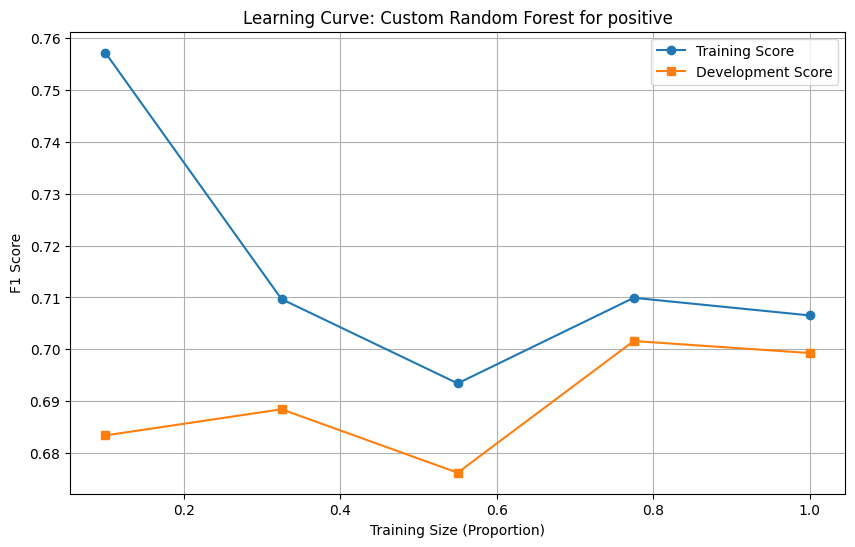

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker="o")
plt.plot(train_sizes, val_scores_mean, label="Development Score", marker="s")
plt.title("Learning Curve: Custom Random Forest for positive")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()


##### Learning curve - accuracy - (for positive)

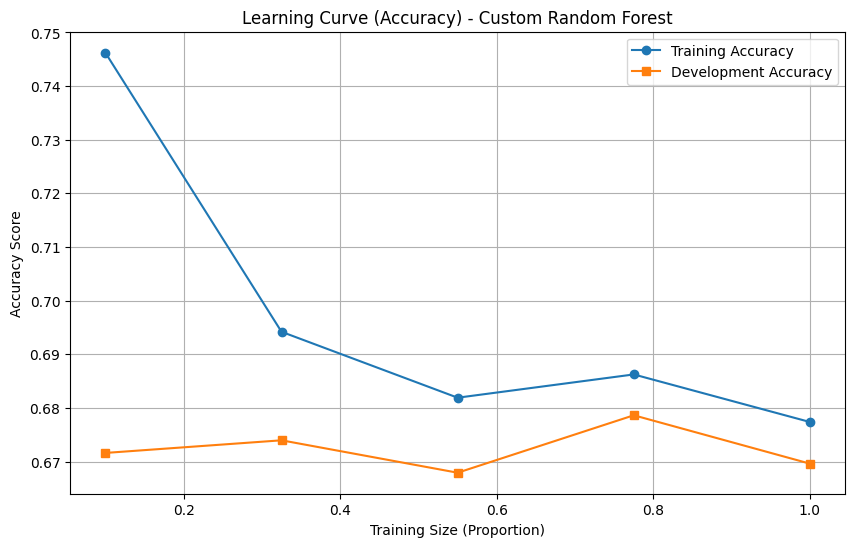

In [11]:
train_scores_acc, val_scores_acc, train_sizes_acc = training_metric(rf, x_train, y_train, score_accuracy)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_acc, train_scores_acc, label="Training Accuracy", marker="o")
plt.plot(train_sizes_acc, val_scores_acc, label="Development Accuracy", marker="s")
plt.title("Learning Curve (Accuracy) - Custom Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

##### Learning curve - precision - (for positive)

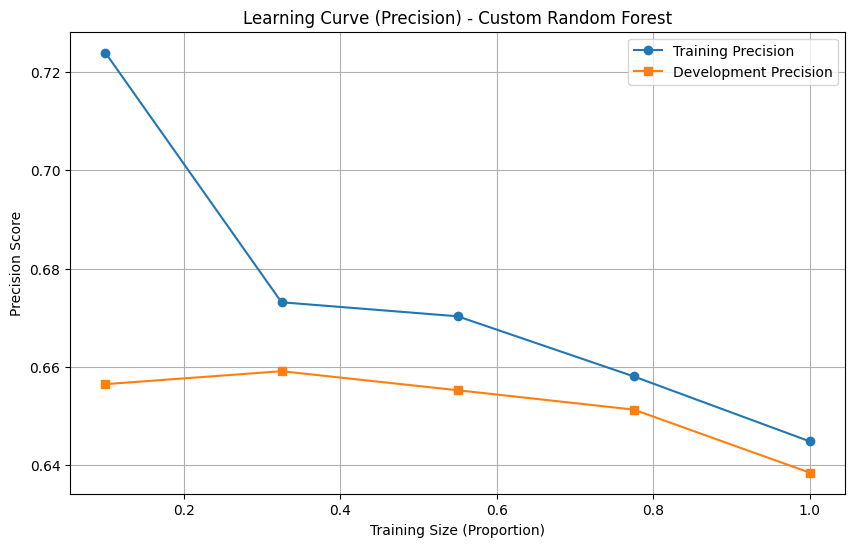

In [ ]:
train_scores_prec, val_scores_prec, train_sizes_prec = training_metric(rf, x_train, y_train, score_precision)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_prec, train_scores_prec, label="Training Precision", marker="o")
plt.plot(train_sizes_prec, val_scores_prec, label="Development Precision", marker="s")
plt.title("Learning Curve (Precision) - Custom Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Precision Score")
plt.legend()
plt.grid()
plt.show()

##### Learning curve - recall - (for positive)

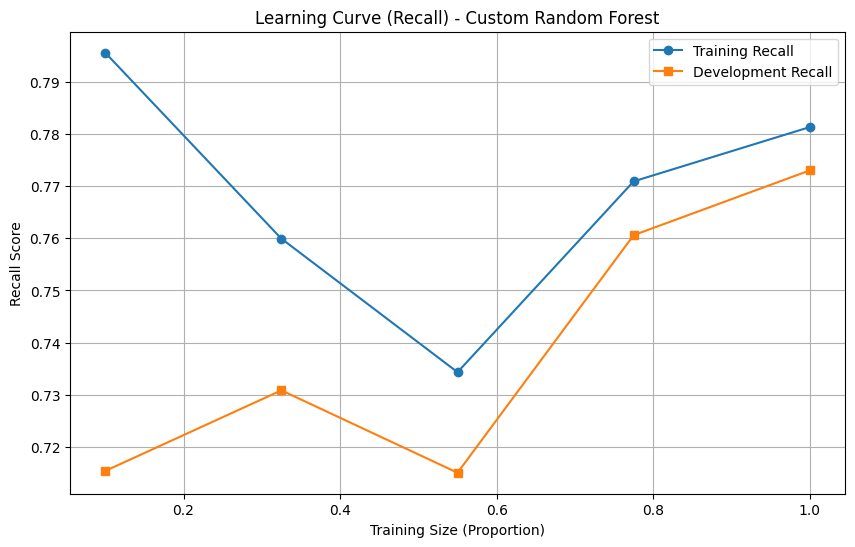

In [13]:
train_scores_rec, val_scores_rec, train_sizes_rec = training_metric(rf, x_train, y_train, score_recall)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_rec, train_scores_rec, label="Training Recall", marker="o")
plt.plot(train_sizes_rec, val_scores_rec, label="Development Recall", marker="s")
plt.title("Learning Curve (Recall) - Custom Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()


#### Αξιολόγηση

##### Μετρικές

In [14]:
from sklearn.metrics import classification_report  # Import classification report

# Predict the validation set using your Random Forest model
predictions = rf.predict(x_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary', zero_division=0)
recall = recall_score(y_test, predictions, average='binary', zero_division=0)
f1 = f1_score(y_test, predictions, average='binary', zero_division=0)

# Print the detailed classification report
class_report = classification_report(y_test, predictions, target_names=["Negative", "Positive"], zero_division=0)

# Print all the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n")
print(class_report)


Accuracy: 0.6836
Precision: 0.6712239583333334
Recall: 0.782839787395596
F1 Score: 0.7227479845776376

Classification Report:

              precision    recall  f1-score   support

    Negative       0.70      0.57      0.63      1183
    Positive       0.67      0.78      0.72      1317

    accuracy                           0.68      2500
   macro avg       0.69      0.68      0.68      2500
weighted avg       0.69      0.68      0.68      2500



In [15]:
from sklearn.metrics import classification_report

# 1. Testing Dataset Classification Report (Detailed Metrics)
test_class_report = classification_report(
    y_test, predictions, target_names=["Negative", "Positive"], output_dict=True, zero_division=0
)

# Extract precision, recall, and F1 scores for both Negative (0) and Positive (1) labels
precision_neg, recall_neg, f1_neg = test_class_report["Negative"]["precision"], test_class_report["Negative"]["recall"], test_class_report["Negative"]["f1-score"]
precision_pos, recall_pos, f1_pos = test_class_report["Positive"]["precision"], test_class_report["Positive"]["recall"], test_class_report["Positive"]["f1-score"]

# Print detailed classification report for testing
print("\nTesting Dataset Classification Report:\n")
print(classification_report(y_test, predictions, target_names=["Negative", "Positive"], zero_division=0))

# 2. Training Dataset Classification Report
train_predictions = rf.predict(x_train)  # Predict on the training data
train_class_report = classification_report(
    y_train, train_predictions, target_names=["Negative", "Positive"], output_dict=True, zero_division=0
)

# Print detailed classification report for training
print("\nTraining Dataset Classification Report:\n")
print(classification_report(y_train, train_predictions, target_names=["Negative", "Positive"], zero_division=0))




Testing Dataset Classification Report:

              precision    recall  f1-score   support

    Negative       0.70      0.57      0.63      1183
    Positive       0.67      0.78      0.72      1317

    accuracy                           0.68      2500
   macro avg       0.69      0.68      0.68      2500
weighted avg       0.69      0.68      0.68      2500


Training Dataset Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.59      0.65     11317
    Positive       0.65      0.77      0.70     11183

    accuracy                           0.68     22500
   macro avg       0.69      0.68      0.68     22500
weighted avg       0.69      0.68      0.68     22500



##### Γραφικές παραστάσεις

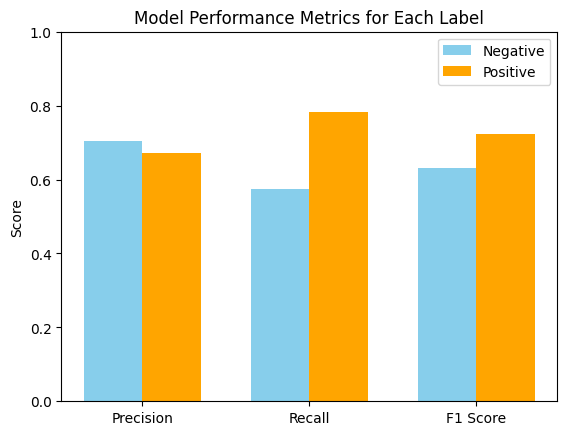

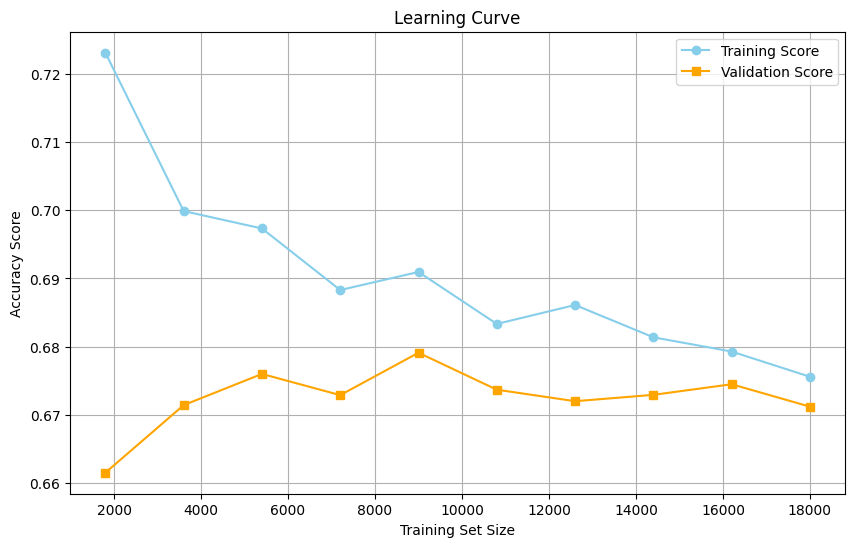

In [16]:
# 3. Combine Metrics for Bar Chart (Metrics for Each Label)
metrics_neg = [precision_neg, recall_neg, f1_neg]
metrics_pos = [precision_pos, recall_pos, f1_pos]
metric_names = ["Precision", "Recall", "F1 Score"]

# Plot bar chart
x = np.arange(len(metric_names))  # X positions for labels
width = 0.35  # Bar width

plt.bar(x - width/2, metrics_neg, width, label="Negative", color="skyblue")
plt.bar(x + width/2, metrics_pos, width, label="Positive", color="orange")

plt.title("Model Performance Metrics for Each Label")
plt.ylabel("Score")
plt.xticks(x, metric_names)
plt.ylim(0, 1)
plt.legend()
plt.show()

# 4. Plot Learning Curve (Custom Implementation)
def plot_learning_curve(estimator, X_train, y_train, title="Learning Curve"):
    """
    Plots the learning curve for the model.
    """
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", marker="o", color="skyblue")
    plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker="s", color="orange")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend()
    plt.grid()
    plt.show()

# Use the function to plot the learning curve for your RandomForest implementation
plot_learning_curve(rf, x_train, y_train)

##### Confusion Matrix

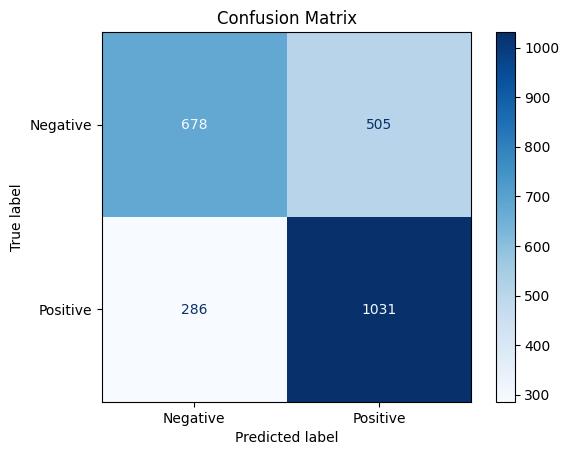

In [17]:
cm = confusion_matrix(y_test, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Αναζήτηση παραμέτρων βέλτιστου μοντέλου

Εύρεση hyper-parameters


- `num_words`
- `skip_top`
- `max_len`
- `n_estimators`
- `max_depth`
- `max_features`

Μέθοδος Επιλογής : Brute forcing experimentation

Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 3, Max Features: 100, Accuracy: 0.6820, Precision: 0.6673, Recall: 0.7904, F1: 0.7237
Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 3, Max Features: 500, Accuracy: 0.6540, Precision: 0.6223, Recall: 0.8732, F1: 0.7267
Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 3, Max Features: 1000, Accuracy: 0.6540, Precision: 0.6223, Recall: 0.8732, F1: 0.7267
Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 5, Max Features: 100, Accuracy: 0.6800, Precision: 0.6631, Recall: 0.7980, F1: 0.7243
Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 5, Max Features: 500, Accuracy: 0.6816, Precision: 0.6617, Recall: 0.8094, F1: 0.7281
Skip Top: 20, Num Words: 5000, Max Len: 100, N Estimators: 10, Max Depth: 5, Max Features: 1000, Accuracy: 0.6816, Precision: 0.6617, Recall: 0.8094, F1: 0.7281
Skip Top: 20, Num Words: 5000, Max Len

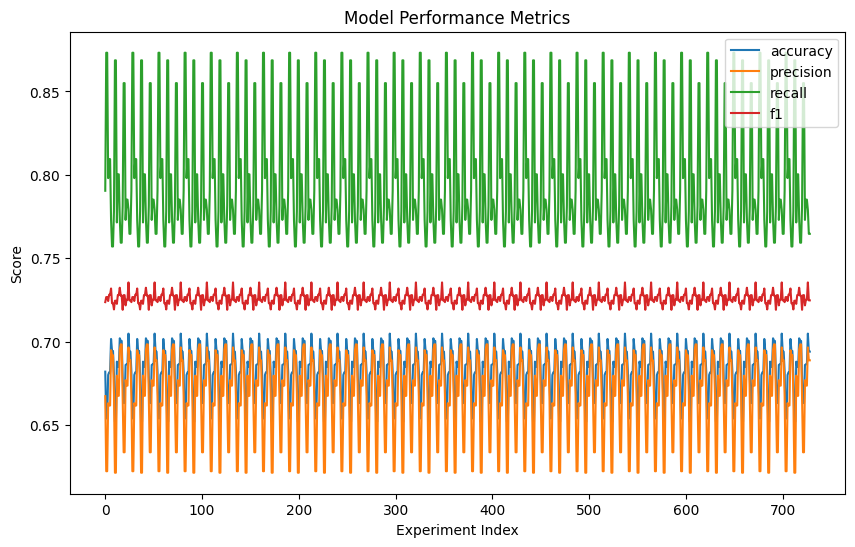

In [18]:
results = []

for skip_top in [20, 50, 100]:
    for num_words in [5000, 10000, 20000]:
        for max_len in [100, 200, 300]:
            for n_estimators in [10, 20, 50]:
                for max_depth in [3, 5, 10]:
                    for max_features in [100, 500, 1000]:
                        rf = RandomForestTree(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=42)
                        rf.fit(x_train, y_train)
                        predictions = rf.predict(x_test)

                        accuracy = accuracy_score(y_test, predictions)
                        precision = precision_score(y_test, predictions, average='binary', zero_division=0)
                        recall = recall_score(y_test, predictions, average='binary', zero_division=0)
                        f1 = f1_score(y_test, predictions, average='binary', zero_division=0)

                        results.append({
                            'skip_top': skip_top,
                            'num_words': num_words,
                            'max_len': max_len,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'max_features': max_features,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'f1': f1
                        })

                        print(f"Skip Top: {skip_top}, Num Words: {num_words}, Max Len: {max_len}, N Estimators: {n_estimators}, Max Depth: {max_depth}, Max Features: {max_features}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

sorted_results = sorted(results, key=lambda x: x['f1'], reverse=True)
best_result = sorted_results[0]

print("\nBest Result:")
print(best_result)

metrics = ['accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(10, 6))
for metric in metrics:
    values = [r[metric] for r in results]
    plt.plot(range(len(results)), values, label=metric)

plt.title("Model Performance Metrics")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend()
plt.show()

### Βέλτιστο μοντέλο

Οι καλύτερες παραμέτροι είναι: 

```bash
{'skip_top': 20, 'num_words': 5000, 'max_len': 300, 'n_estimators': 50, 'max_depth': 10, 'max_features': 100, 'accuracy': 0.71704, 'precision': 0.6921660291826037, 'recall': 0.78176, 'f1': 0.73423998797806}
```

#### Εκπαίδευση

In [19]:
# Assume x_train, y_train, x_val, y_val are already preloaded and preprocessed consistently

# Initialize and train the RandomForestTree
rf = RandomForestTree(n_estimators=50, max_depth=10, max_features=100, random_state=42)

# Train the model on the preprocessed training data
rf.fit(x_train, y_train)

# Make predictions on the validation set
predictions = rf.predict(x_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary', zero_division=0)
recall = recall_score(y_test, predictions, average='binary', zero_division=0)
f1 = f1_score(y_test, predictions, average='binary', zero_division=0)

# Output the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7048
Precision: 0.6965376782077393
Recall: 0.7790432801822323
F1 Score: 0.7354838709677419


#### Καμπύλες μάθησης

##### Learning Curve - F1 Score (for positive)

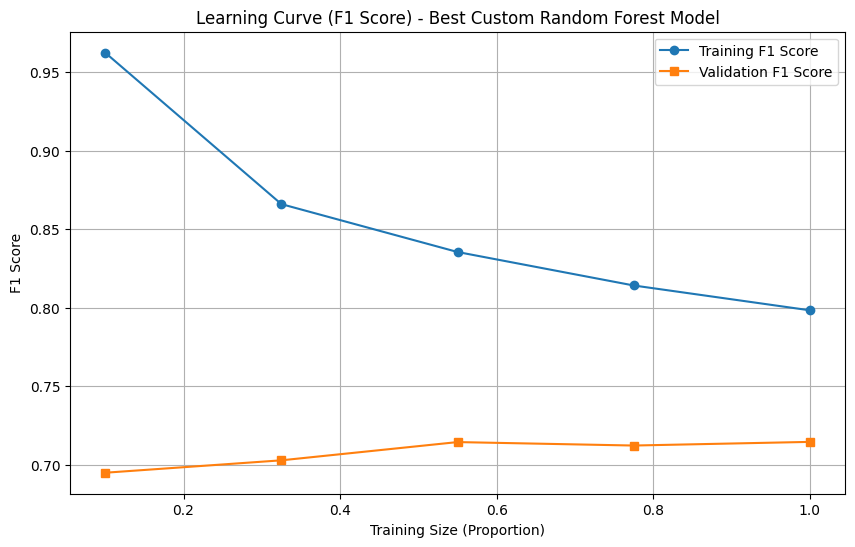

In [20]:
train_scores_best_f1, val_scores_best_f1, train_sizes_best = training_metric(rf, x_train, y_train, score_f1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_best, train_scores_best_f1, label="Training F1 Score", marker="o")
plt.plot(train_sizes_best, val_scores_best_f1, label="Validation F1 Score", marker="s")
plt.title("Learning Curve (F1 Score) - Best Custom Random Forest Model")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Accuracy (for positive)

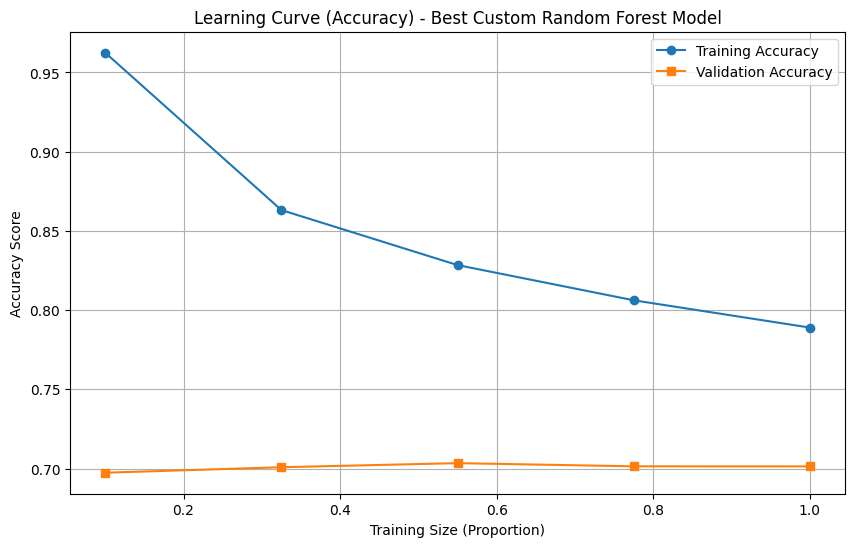

In [21]:
train_scores_best_acc, val_scores_best_acc, train_sizes_best = training_metric(rf, x_train, y_train, score_accuracy)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_best, train_scores_best_acc, label="Training Accuracy", marker="o")
plt.plot(train_sizes_best, val_scores_best_acc, label="Validation Accuracy", marker="s")
plt.title("Learning Curve (Accuracy) - Best Custom Random Forest Model")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Precision (for positive)

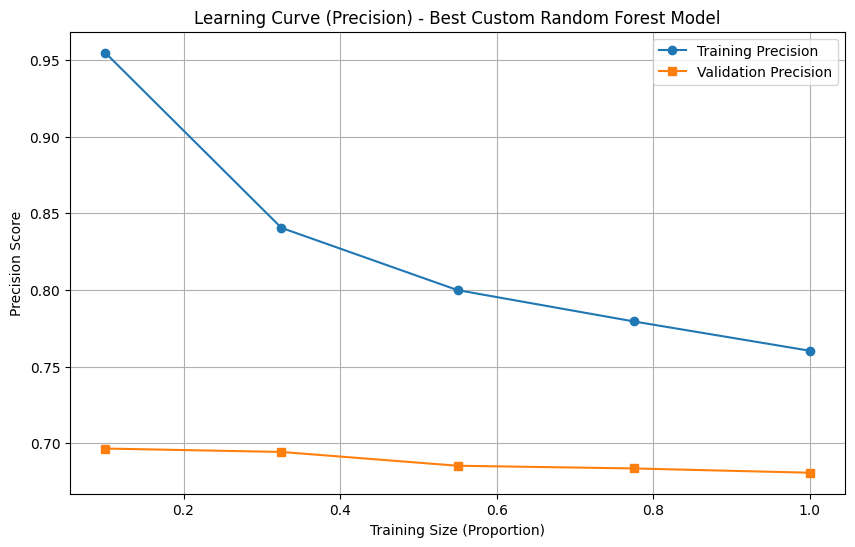

In [22]:
train_scores_best_prec, val_scores_best_prec, train_sizes_best = training_metric(rf, x_train, y_train, score_precision)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_best, train_scores_best_prec, label="Training Precision", marker="o")
plt.plot(train_sizes_best, val_scores_best_prec, label="Validation Precision", marker="s")
plt.title("Learning Curve (Precision) - Best Custom Random Forest Model")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Precision Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Recall (for positive)

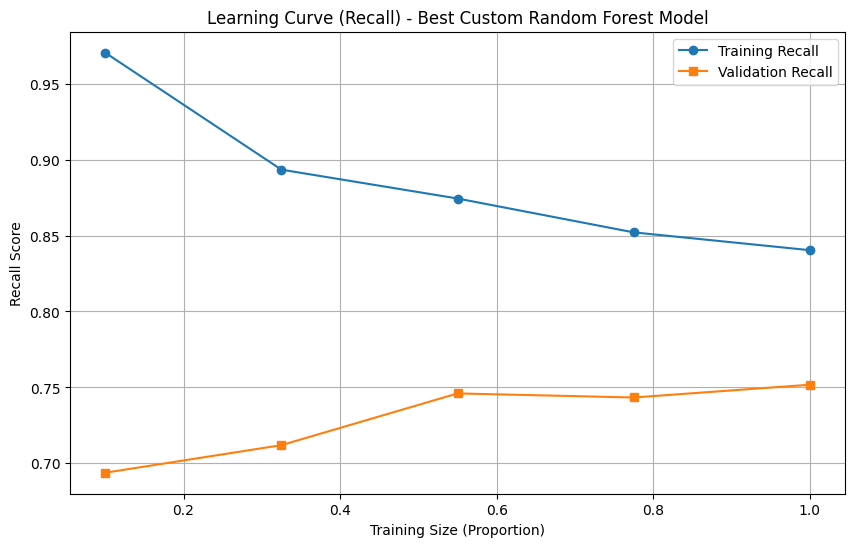

In [23]:
train_scores_best_rec, val_scores_best_rec, train_sizes_best = training_metric(rf, x_train, y_train, score_recall)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_best, train_scores_best_rec, label="Training Recall", marker="o")
plt.plot(train_sizes_best, val_scores_best_rec, label="Validation Recall", marker="s")
plt.title("Learning Curve (Recall) - Best Custom Random Forest Model")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()

#### Αξιολόγηση

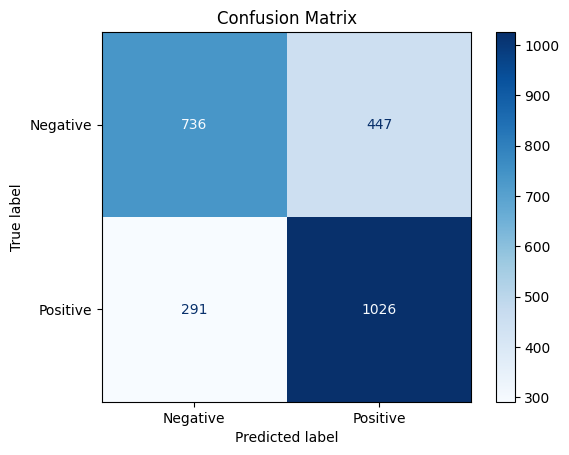

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.62      0.67      1183
    Positive       0.70      0.78      0.74      1317

    accuracy                           0.70      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.71      0.70      0.70      2500



In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Add a classification report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Negative", "Positive"]))


### Μοντέλο του sci kit learn

#### Ορισμός του μοντέλου του scikit-learn

In [25]:
from sklearn.ensemble import RandomForestClassifier
best_model_sklearn_rf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=100, random_state=42)
best_model_sklearn_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features=100, n_estimators=50,
                       random_state=42)

#### Εκπαίδευση

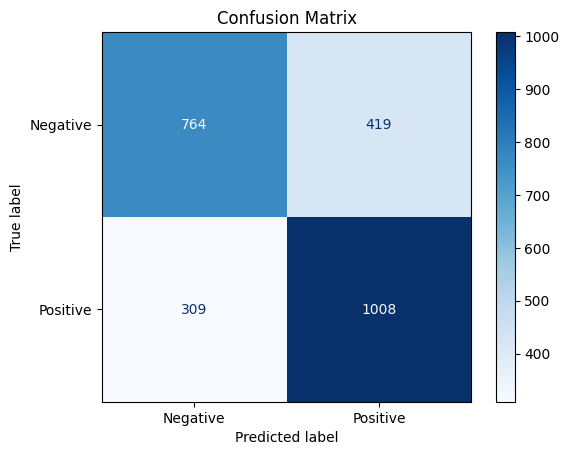

In [26]:
# Predict on the validation set using the tuned scikit-learn Random Forest model
sc_predictions = best_model_sklearn_rf.predict(x_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, sc_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


#### Καμπύλες μάθησης

##### Learning Curve - F1 Score (for positive) - Scikit-learn

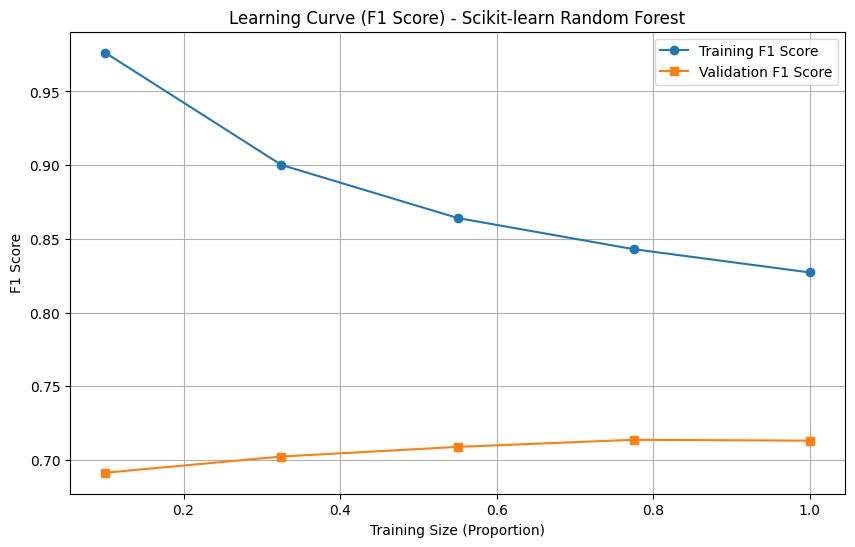

In [27]:
train_scores_sklearn_f1, val_scores_sklearn_f1, train_sizes_sklearn = training_metric(best_model_sklearn_rf, x_train, y_train, score_f1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_sklearn, train_scores_sklearn_f1, label="Training F1 Score", marker="o")
plt.plot(train_sizes_sklearn, val_scores_sklearn_f1, label="Validation F1 Score", marker="s")
plt.title("Learning Curve (F1 Score) - Scikit-learn Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Accuracy (for positive) - Scikit-learn

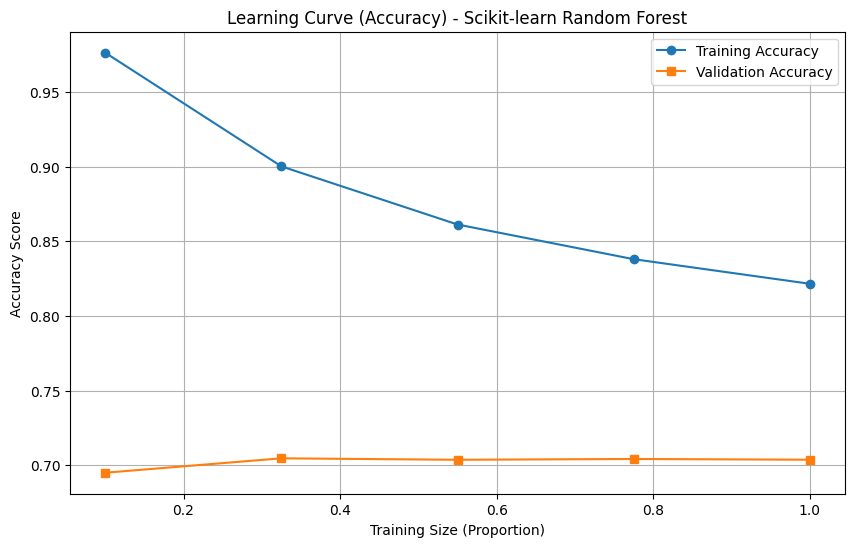

In [28]:
train_scores_sklearn_acc, val_scores_sklearn_acc, train_sizes_sklearn = training_metric(best_model_sklearn_rf, x_train, y_train, score_accuracy)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_sklearn, train_scores_sklearn_acc, label="Training Accuracy", marker="o")
plt.plot(train_sizes_sklearn, val_scores_sklearn_acc, label="Validation Accuracy", marker="s")
plt.title("Learning Curve (Accuracy) - Scikit-learn Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Precision (for positive) - Scikit-learn

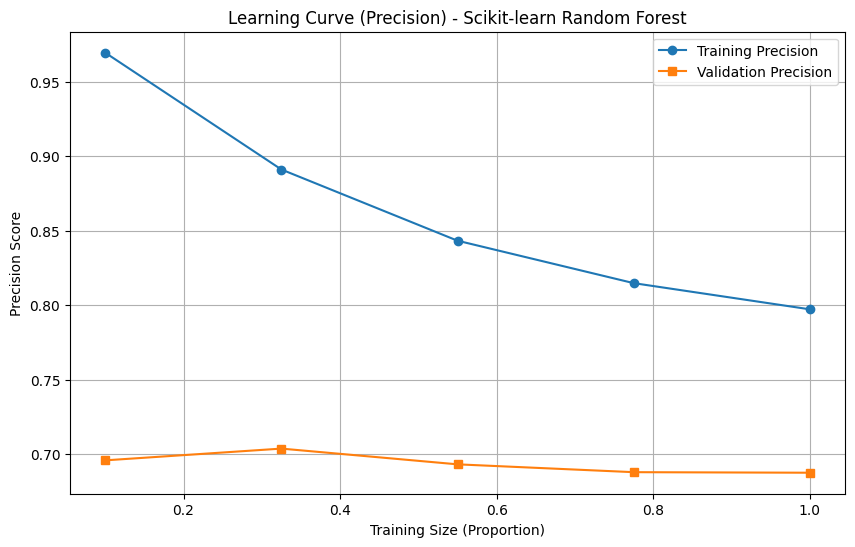

In [29]:
train_scores_sklearn_prec, val_scores_sklearn_prec, train_sizes_sklearn = training_metric(best_model_sklearn_rf, x_train, y_train, score_precision)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_sklearn, train_scores_sklearn_prec, label="Training Precision", marker="o")
plt.plot(train_sizes_sklearn, val_scores_sklearn_prec, label="Validation Precision", marker="s")
plt.title("Learning Curve (Precision) - Scikit-learn Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Precision Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Recall (for positive) - Scikit-learn

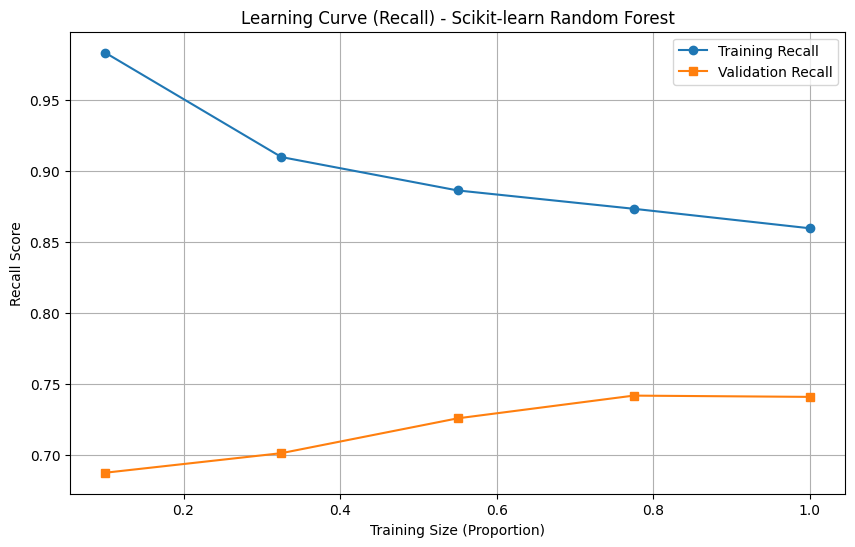

In [30]:
train_scores_sklearn_rec, val_scores_sklearn_rec, train_sizes_sklearn = training_metric(best_model_sklearn_rf, x_train, y_train, score_recall)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_sklearn, train_scores_sklearn_rec, label="Training Recall", marker="o")
plt.plot(train_sizes_sklearn, val_scores_sklearn_rec, label="Validation Recall", marker="s")
plt.title("Learning Curve (Recall) - Scikit-learn Random Forest")
plt.xlabel("Training Size (Proportion)")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()

#### Εναρμονισμός του validation set

In [31]:
# Defining a separate validation set, use x_test and y_test as the validation set.
x_val, y_val = x_test, y_test

#### Αξιολόγηση

Scikit-learn Random Forest Evaluation Metrics:
Accuracy: 0.7028
Precision: 0.7015
Recall: 0.7585
F1 Score: 0.7289

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.64      0.67      1183
    Positive       0.70      0.76      0.73      1317

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



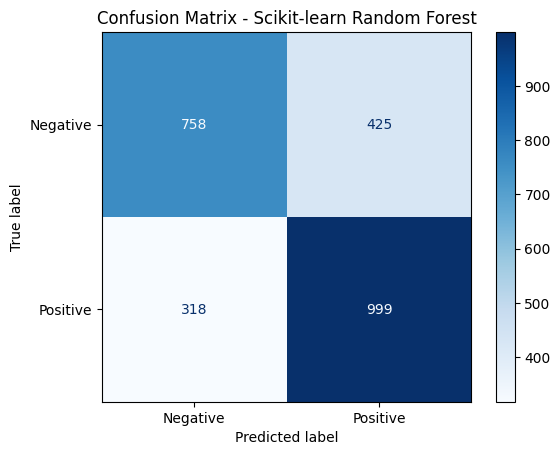

In [32]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Predict using the scikit-learn model on the validation set
sc_predictions = best_model_sklearn_rf.predict(x_val)

# Calculate evaluation metrics for scikit-learn Random Forest
sc_accuracy = accuracy_score(y_val, sc_predictions)
sc_precision = precision_score(y_val, sc_predictions, average="binary", zero_division=0)
sc_recall = recall_score(y_val, sc_predictions, average="binary", zero_division=0)
sc_f1 = f1_score(y_val, sc_predictions, average="binary", zero_division=0)

# Output the metrics
print("Scikit-learn Random Forest Evaluation Metrics:")
print(f"Accuracy: {sc_accuracy:.4f}")
print(f"Precision: {sc_precision:.4f}")
print(f"Recall: {sc_recall:.4f}")
print(f"F1 Score: {sc_f1:.4f}\n")

# Display the classification report
print("Classification Report:")
print(classification_report(y_val, sc_predictions, target_names=["Negative", "Positive"], zero_division=0))

# Plot the confusion matrix
cm_sc = confusion_matrix(y_val, sc_predictions, labels=[0, 1])
disp_sc = ConfusionMatrixDisplay(confusion_matrix=cm_sc, display_labels=["Negative", "Positive"])
disp_sc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Scikit-learn Random Forest")
plt.show()


## Σύγκριση βέλτιστου μοντέλου με αυτό της βιβλιοθήκης

### Μετρικές

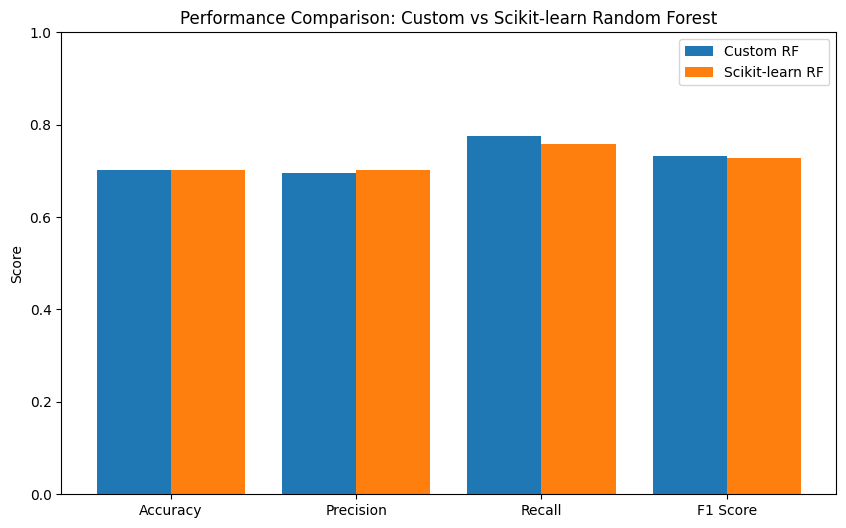


Training Classification Report (Custom RF):
              precision    recall  f1-score   support

    Negative       0.81      0.71      0.75     11317
    Positive       0.74      0.83      0.78     11183

    accuracy                           0.77     22500
   macro avg       0.77      0.77      0.77     22500
weighted avg       0.77      0.77      0.77     22500


Testing Classification Report (Custom RF):
              precision    recall  f1-score   support

    Negative       0.71      0.62      0.66      1183
    Positive       0.70      0.78      0.73      1317

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500


Training Classification Report (Scikit-learn RF):
              precision    recall  f1-score   support

    Negative       0.82      0.76      0.79     11317
    Positive       0.77      0.83      0.80     11183

    accuracy                           0.7

In [33]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Custom Random Forest Predictions and Metrics
predictions = rf.predict(x_val)  # Ensure predictions are for the validation set
custom_accuracy = accuracy_score(y_val, predictions)
custom_precision = precision_score(y_val, predictions, average="binary", zero_division=0)
custom_recall = recall_score(y_val, predictions, average="binary", zero_division=0)
custom_f1 = f1_score(y_val, predictions, average="binary", zero_division=0)
custom_values = [custom_accuracy, custom_precision, custom_recall, custom_f1]

# Scikit-learn Random Forest Predictions and Metrics
sc_predictions = best_model_sklearn_rf.predict(x_val)
sc_accuracy = accuracy_score(y_val, sc_predictions)
sc_precision = precision_score(y_val, sc_predictions, average="binary", zero_division=0)
sc_recall = recall_score(y_val, sc_predictions, average="binary", zero_division=0)
sc_f1 = f1_score(y_val, sc_predictions, average="binary", zero_division=0)
scikit_values = [sc_accuracy, sc_precision, sc_recall, sc_f1]

# Visualization: Comparison of Custom and Scikit-learn Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.bar(x, custom_values, width=0.4, label="Custom RF", align="center")
plt.bar([i + 0.4 for i in x], scikit_values, width=0.4, label="Scikit-learn RF", align="center")
plt.xticks([i + 0.2 for i in x], metrics)
plt.title("Performance Comparison: Custom vs Scikit-learn Random Forest")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.show()

# Training and Testing Classification Reports
print("\nTraining Classification Report (Custom RF):")
train_predictions = rf.predict(x_train)
print(classification_report(y_train, train_predictions, target_names=["Negative", "Positive"]))

print("\nTesting Classification Report (Custom RF):")
print(classification_report(y_val, predictions, target_names=["Negative", "Positive"]))

print("\nTraining Classification Report (Scikit-learn RF):")
sc_train_predictions = best_model_sklearn_rf.predict(x_train)
print(classification_report(y_train, sc_train_predictions, target_names=["Negative", "Positive"]))

print("\nTesting Classification Report (Scikit-learn RF):")
print(classification_report(y_val, sc_predictions, target_names=["Negative", "Positive"]))


### Μέρος Γ’: Στοιβαγμένο Διπλής Κατεύθυνσης LSTM με Global Max Pooling

#### 1. Βιβλιοθήκες & Προετοιμασία Δεδομένων

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score)
import gensim.downloader as api
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# IMDB dataset parameters
num_words = 10000
max_len = 200

# Load IMDB dataset (from Keras)
(x_train_seq, y_train), (x_test_seq, y_test) = imdb.load_data(num_words=num_words, skip_top=20)
# Split out a validation set from the original training data (10% for validation)
x_train_seq, x_val_seq, y_train, y_val = train_test_split(x_train_seq, y_train, test_size=0.1, random_state=42)

# Pad sequences so that all reviews have the same length
x_train_seq = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_val_seq   = pad_sequences(x_val_seq, maxlen=max_len, padding='post', truncating='post')
x_test_seq  = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

# Build the word-index mapping (adjusted by offset)
word_index = imdb.get_word_index()
word_index = {word: (idx+3) for word, idx in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# Create a reverse mapping for indices (only for indices < num_words)
index_word = {idx: word for word, idx in word_index.items() if idx < num_words}

# Load pre-trained Word2Vec embeddings (Google News, 300 dimensions)
print("Loading pre-trained Word2Vec embeddings (this may take a while)...")
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Build the embedding matrix for our vocabulary (indices 0 to num_words-1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for i in range(num_words):
    if i < 4:
        embedding_matrix[i] = np.zeros(embedding_dim)  # For special tokens
    else:
        word = index_word.get(i, None)
        if word is not None and word in word2vec:
            embedding_matrix[i] = word2vec[word]
        else:
            # If the word is not found, initialize randomly (normal distribution)
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Convert the sequences and labels into PyTorch tensors
x_train_tensor = torch.tensor(x_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor   = torch.tensor(x_val_seq, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor  = torch.tensor(x_test_seq, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders for training, validation, and testing
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

print("Data preparation complete.")

Using device: cpu
Loading pre-trained Word2Vec embeddings (this may take a while)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Data preparation complete.


#### 2. Ορισμός του Μοντέλου: Stacked BiLSTM με Global Max Pooling

In [35]:
class StackedBiLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, output_dim, embedding_matrix):
        super(StackedBiLSTM, self).__init__()
        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze embeddings (set True to fine-tune)
        
        # Stacked bidirectional LSTM (output dimension = hidden_dim * 2)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True)
        # Fully connected layer maps the pooled features to the binary output
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)           # (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.lstm(embedded)        # (batch_size, seq_len, hidden_dim*2)
        # Global max pooling over the sequence dimension
        pooled, _ = torch.max(lstm_out, dim=1)   # (batch_size, hidden_dim*2)
        logits = self.fc(pooled)                 # (batch_size, output_dim)
        return torch.sigmoid(logits)

# Hyperparameters for the LSTM model
num_layers = 2
hidden_dim = 64
output_dim = 1

# Instantiate the model
model_rnn = StackedBiLSTM(num_embeddings=num_words, embedding_dim=embedding_dim,
                          hidden_dim=hidden_dim, num_layers=num_layers,
                          output_dim=output_dim, embedding_matrix=embedding_matrix)
model_rnn = model_rnn.to(device)
print(model_rnn)

StackedBiLSTM(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


#### 3. Εκπαίδευση και Επιλογή Καλύτερης Εποχής

In [36]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)
epochs = 10  # Adjust this number based on experimentation

best_val_loss = float('inf')
best_model_state = None
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_rnn.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_rnn(x_batch).squeeze()  # Shape: (batch_size,)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation step
    model_rnn.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model_rnn(x_batch).squeeze()
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # Save best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model_rnn.state_dict()

# Load best model state (lowest validation loss)
model_rnn.load_state_dict(best_model_state)
print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))

Epoch 1/10 - Train Loss: 0.4284, Val Loss: 0.3884
Epoch 2/10 - Train Loss: 0.3379, Val Loss: 0.3606
Epoch 3/10 - Train Loss: 0.3039, Val Loss: 0.3377
Epoch 4/10 - Train Loss: 0.2771, Val Loss: 0.3489
Epoch 5/10 - Train Loss: 0.2481, Val Loss: 0.3322
Epoch 6/10 - Train Loss: 0.2171, Val Loss: 0.3595
Epoch 7/10 - Train Loss: 0.1839, Val Loss: 0.3459
Epoch 8/10 - Train Loss: 0.1533, Val Loss: 0.3889
Epoch 9/10 - Train Loss: 0.1232, Val Loss: 0.4225
Epoch 10/10 - Train Loss: 0.0924, Val Loss: 0.4600
Training complete. Best validation loss: 0.3322


#### 4. Καμπύλες Απώλειας

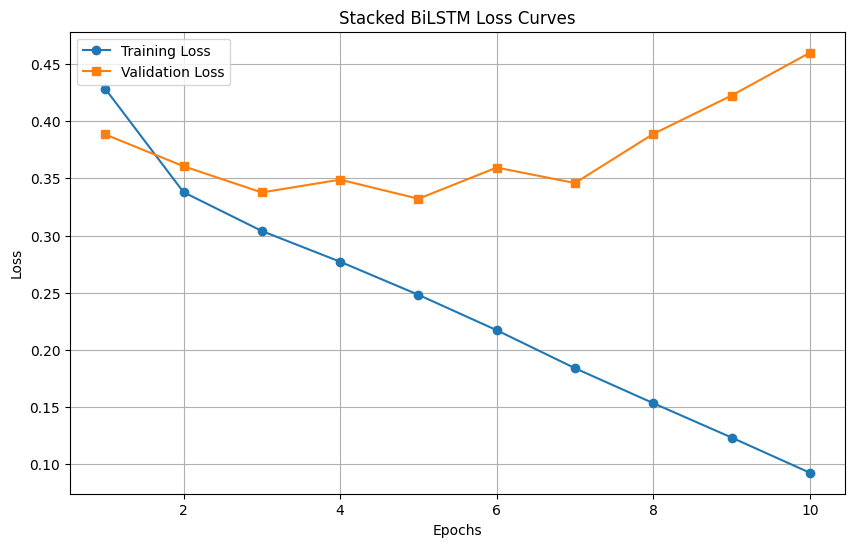

In [37]:
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Stacked BiLSTM Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

#### 5. Τελική Αξιολόγηση στο Test Set

In [38]:
model_rnn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model_rnn(x_batch).squeeze()
        preds = (outputs > 0.5).float()  # Apply threshold of 0.5 for binary classification
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy_rnn = accuracy_score(all_labels, all_preds)
precision_rnn = precision_score(all_labels, all_preds, zero_division=0)
recall_rnn = recall_score(all_labels, all_preds, zero_division=0)
f1_rnn = f1_score(all_labels, all_preds, zero_division=0)

print("Stacked BiLSTM Test Metrics:")
print(f"Accuracy:  {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall:    {recall_rnn:.4f}")
print(f"F1 Score:  {f1_rnn:.4f}\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"], zero_division=0))

Stacked BiLSTM Test Metrics:
Accuracy:  0.8614
Precision: 0.8560
Recall:    0.8690
F1 Score:  0.8625

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     12500
    Positive       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

